### Loading needed packages

In [1]:
import os
import torch
import clip
import pandas as pd
import numpy as np
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt
from glob import glob
from PIL import Image
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms, utils
from skimage import io, transform
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from torch.utils.data import DataLoader
from tqdm import tqdm

/home/ws-cluster-03/anaconda3/envs/murtadha/lib/python3.7/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


### Loading CLIP pretrained model 'ViT-B/32' and associated input preprocessor

In [2]:
device = "cuda" if torch.cuda.is_available() else "cpu"
model, preprocess = clip.load("ViT-B/32", device=device)
device

'cuda'

### Loading Dataset

In [3]:
root_pth = './CUB_200_2011/CUB_200_2011/images'
imgID_pth_df = pd.read_csv('./CUB_200_2011/CUB_200_2011/images.txt', sep=' ', header=None, names=['img_id', 'sub_pth'])
train_split_df = pd.read_csv('./CUB_200_2011/CUB_200_2011/train_test_split.txt', sep=' ', names=['img_id', 'is_training'])
class_names = pd.read_csv('./CUB_200_2011/CUB_200_2011/classes.txt', sep=' ', header=None, names=['class_id', 'class_name'])
class_names.class_name = class_names.class_name.map(lambda x: x.split('.')[1].lower())

cub_dataset_df = imgID_pth_df.merge(train_split_df, on='img_id', how='inner')
cub_dataset_df

,img_id,sub_pth,is_training
0,1,001.Black_footed_Albatross/Black_Footed_Albatr...,0
1,2,001.Black_footed_Albatross/Black_Footed_Albatr...,1
2,3,001.Black_footed_Albatross/Black_Footed_Albatr...,0
3,4,001.Black_footed_Albatross/Black_Footed_Albatr...,1
4,5,001.Black_footed_Albatross/Black_Footed_Albatr...,1
...,...,...,...
11783,11784,200.Common_Yellowthroat/Common_Yellowthroat_00...,1
11784,11785,200.Common_Yellowthroat/Common_Yellowthroat_00...,0
11785,11786,200.Common_Yellowthroat/Common_Yellowthroat_00...,0
11786,11787,200.Common_Yellowthroat/Common_Yellowthroat_00...,1


### Creating the CUB-200-2011 dataset class for loading

In [4]:
class CUBDataset(Dataset):
    """CUB dataset."""

    def __init__(self, dataframe, root_dir, class_names_df, transform=None):
        """
        Args:
            dataframe (pd.DataFrame): Dataframe with paths and train/test split information.
            root_dir (string): Root directory with all the images.
            transform (callable, optional): Optional transform to be applied
                on a sample.
        """
        self.cub_img_df = dataframe
        self.root_dir = root_dir
        self.transform = transform
        self.class_ids_names_dict = {name:class_id-1 for class_id, name in class_names.values}

    def __len__(self):
        return len(self.cub_img_df)

    def __getitem__(self, idx):
        if torch.is_tensor(idx):
            idx = idx.tolist()
        
        sub_pth = self.cub_img_df.iloc[idx, 1]
        img_name = os.path.join(self.root_dir, sub_pth)
        image = io.imread(img_name)
        target = sub_pth.split('/')[0].split('.')[1].lower()
        if self.transform:
            image = self.transform(image)
        return image, self.class_ids_names_dict[target]

### Calculating zero-shot accuracy on the testing portion of CUB-200-2011 dataset with no change to the pretrained model

In [5]:
# loading CUB-200-2011 test dataset
train_set = CUBDataset(cub_dataset_df[cub_dataset_df.is_training==1], root_pth, class_names, transform=transforms.Compose([transforms.ToPILImage(), preprocess]))
test_set = CUBDataset(cub_dataset_df[cub_dataset_df.is_training==0], root_pth, class_names,  transform=transforms.Compose([transforms.ToPILImage(), preprocess]))

In [6]:
bs = 512
train_loader = DataLoader(dataset=train_set, batch_size=bs, shuffle=True)
test_loader = DataLoader(dataset=test_set, batch_size=bs, shuffle=False)

In [7]:
classes = class_names.class_name.tolist() # 200 classes from CUB-200-2011 dataset

# defining the text prompt for the zero-shot predictions
# Alos, need to encode and clculate text features of the prompts only once
text_inputs = torch.cat([clip.tokenize(f"a photo of a {c}") for c in classes]).to(device)
with torch.no_grad():
    text_features = model.encode_text(text_inputs)
text_features /= text_features.norm(dim=-1, keepdim=True)
    
res = [] # to store the zero-shot predctions

for images, class_ids in test_loader:
    images = images.to(device)
    with torch.no_grad():
        image_features = model.encode_image(images)
        
    image_features /= image_features.norm(dim=-1, keepdim=True)

    # Pick the top 1 most similar labels for the image
    similarity = (100.0 * image_features @ text_features.T).softmax(dim=-1)
    values, indices = similarity.topk(1)

    for i in range(len(indices)):
        for value, index in zip(values[i], indices[i]):
            res.append([index,class_ids[i],value.item()])

In [8]:
print(f'Zero-shot accuracy over CUB-200-2011 (no changes to pretrained model) = ', end='')
print(f'{np.round(np.mean([1 if item[0]==item[1] else 0 for item in res])*100., 2)}%')

Zero-shot accuracy over CUB-200-2011 (no changes to pretrained model) = 45.55%


In [9]:
def get_features(dataloader):
    all_features = []
    all_labels = []
    
    with torch.no_grad():
        for images, labels in tqdm(dataloader):
            features = model.encode_image(images.to(device))

            all_features.append(features)
            all_labels.append(labels)

    return torch.cat(all_features).cpu().numpy(), torch.cat(all_labels).cpu().numpy()

In [ ]:
# https://github.com/openai/CLIP/issues/83

device = "cuda:0" if torch.cuda.is_available() else "cpu" # If using GPU then use mixed precision training.
model, _ = clip.load("ViT-B/32",device=device,jit=False) #Must set jit=False for training

class image_title_dataset(Dataset):
    def __init__(self, list_image_path,list_txt):

        self.image_path = list_image_path
        self.title  = clip.tokenize(list_txt) #you can tokenize everything at once in here(slow at the beginning), or tokenize it in the training loop.

    def __len__(self):
        return len(self.title)

    def __getitem__(self, idx):
        image = preprocess(Image.open(self.image_path[idx])) # Image from PIL module
        title = self.title[idx]
        return image,title

def get_txt(pth):
    txt = ''
    with open(pth) as f:
        for l in f:
            txt += l
            break
    return txt
    
# use your own data
list_image_path = glob(os.path.join(root_pth,'**/*.jpg'))
list_txt = [get_txt(img_pth.replace('/images','/text')[:-4]+'.txt') for img_pth in list_image_path]

dataset = image_title_dataset(list_image_path,list_txt)
train_dataloader = DataLoader(dataset,batch_size = 32) #Define your own dataloader

# https://github.com/openai/CLIP/issues/57
def convert_models_to_fp32(model): 
    for p in model.parameters():
        if p.requires_grad == False:
            continue
        p.data = p.data.float() 
        p.grad.data = p.grad.data.float() 


if device == "cpu":
  model.float()
else :
  clip.model.convert_weights(model) # Actually this line is unnecessary since clip by default already on float16

# For freezing weights
# modules = [module for module in model.visual.modules()]
# for p in model.visual.parameters():
#     p.requires_grad = False

# for i in range(95, len(modules)):
#     for p in modules[i].parameters():
#         p.requires_grad = True

loss_img = nn.CrossEntropyLoss()
loss_txt = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=5e-7,betas=(0.9,0.98),eps=1e-6,weight_decay=0.001) #Params used from paper, the lr is smaller, more safe for fine tuning to new dataset

# # add your own code to track the training progress.
for epoch in range(30):
  for images, texts in train_dataloader :
      optimizer.zero_grad()
    
      images, texts = images.to(device), texts.to(device)
    
      logits_per_image, logits_per_text = model(images, texts)

      ground_truth = torch.arange(len(images),dtype=torch.long,device=device)

      total_loss = (loss_img(logits_per_image,ground_truth) + loss_txt(logits_per_text,ground_truth))/2
      total_loss.backward()
      if device == "cpu":
         optimizer.step()
      else : 
        convert_models_to_fp32(model)
        optimizer.step()
        clip.model.convert_weights(model)
  train_features, train_labels = get_features(train_loader)
  test_features, test_labels = get_features(test_loader)
  classifier = KNeighborsClassifier(n_neighbors=5)
  classifier.fit(train_features, train_labels)

  # Evaluate using the logistic regression classifier
  predictions = classifier.predict(test_features)
  accuracy = np.mean((test_labels == predictions).astype(float)) * 100.
  print(f'{epoch} - {total_loss} - {accuracy}')


100%|██████████| 12/12 [00:33<00:00,  2.76s/it]


0 - 2.61328125 - 58.59509837763204


100%|██████████| 12/12 [00:33<00:00,  2.77s/it]


1 - 2.509765625 - 59.250949257852945


100%|██████████| 12/12 [00:33<00:00,  2.77s/it]


2 - 2.462890625 - 59.63065239903348


100%|██████████| 12/12 [00:34<00:00,  2.84s/it]


3 - 2.4375 - 60.09665170866414


100%|██████████| 12/12 [00:33<00:00,  2.78s/it]


4 - 2.4140625 - 60.59716948567484


100%|██████████| 12/12 [00:33<00:00,  2.78s/it]


5 - 2.39453125 - 61.27027959958578


100%|██████████| 12/12 [00:33<00:00,  2.76s/it]


6 - 2.37109375 - 61.615464273386266


100%|██████████| 12/12 [00:33<00:00,  2.77s/it]


7 - 2.359375 - 61.977908180876774


100%|██████████| 12/12 [00:33<00:00,  2.82s/it]


8 - 2.34375 - 61.9951674145668


In [ ]:
# saving the model

# torch.save({
#         'epoch': epoch,
#         'model_state_dict': model.state_dict(),
#         'optimizer_state_dict': optimizer.state_dict(),
#         'loss': total_loss,
#         }, f"model_30_5e7_001_fixed.pt")

In [ ]:
# Load the model
model, preprocess = clip.load("ViT-B/32",device=device,jit=False) #Must set jit=False for training

# Calculate the image features
train_features, train_labels = get_features(train_loader)
test_features, test_labels = get_features(test_loader)

acc_finetuned_pretrained = []
for n_neighbors in range(3,21):
    classifier = KNeighborsClassifier(n_neighbors=n_neighbors)
    classifier.fit(train_features, train_labels)

    # Evaluate using the logistic regression classifier
    predictions = classifier.predict(test_features)
    accuracy = np.mean((test_labels == predictions).astype(float)) * 100.
    print(f"Accuracy = {accuracy:.3f}")
    acc_finetuned_pretrained.append(accuracy)

In [ ]:
# Load the model
model, preprocess = clip.load("ViT-B/32",device=device,jit=False) #Must set jit=False for training
checkpoint = torch.load("model_30_5e7_001_fixed.pt")
model.load_state_dict(checkpoint['model_state_dict'])

# Calculate the image features
train_features, train_labels = get_features(train_loader)
test_features, test_labels = get_features(test_loader)

acc_finetuned_finetuned_30 = []
for n_neighbors in range(3,21):
    classifier = KNeighborsClassifier(n_neighbors=n_neighbors)
    classifier.fit(train_features, train_labels)

    # Evaluate using the logistic regression classifier
    predictions = classifier.predict(test_features)
    accuracy = np.mean((test_labels == predictions).astype(float)) * 100.
    print(f"Accuracy = {accuracy:.3f}")
    acc_finetuned_finetuned_30.append(accuracy)

In [ ]:
# Load the model
device = "cuda" if torch.cuda.is_available() else "cpu"

model, preprocess = clip.load("ViT-B/32",device=device,jit=False) #Must set jit=False for training
checkpoint = torch.load("model_100_5e7_001_fixed.pt")
model.load_state_dict(checkpoint['model_state_dict'])

# Calculate the image features
train_features, train_labels = get_features(train_loader)
test_features, test_labels = get_features(test_loader)

acc_finetuned_finetuned_100 = []
for n_neighbors in range(3,21):
    classifier = KNeighborsClassifier(n_neighbors=n_neighbors)
    classifier.fit(train_features, train_labels)

    # Evaluate using the logistic regression classifier
    predictions = classifier.predict(test_features)
    accuracy = np.mean((test_labels == predictions).astype(float)) * 100.
    print(f"Accuracy = {accuracy:.3f}")
    acc_finetuned_finetuned_100.append(accuracy)

In [ ]:
plt.plot(range(3,19), acc_finetuned_pretrained[:-2])
plt.plot(range(3,19), acc_finetuned_finetuned_30[:-2])
plt.plot(range(3,19), acc_finetuned_finetuned_100[:-2])
plt.xticks(range(2,20))
plt.title('Zero-Shot Accuracy of Pretrained and Finetuned Models')
plt.xlabel('KNN No. of Neighbors')
plt.ylabel('Accuracy (%)')
plt.legend(['Pretrained CLIP (ViT-B/32)', 'Finetuned CLIP (ViT-B/32) - 30 epochs', 'Finetuned CLIP (ViT-B/32) - 100 epochs'])
plt.savefig('zeroshot.png')
plt.show()

In [ ]:
bird_types = ['005.Crested_Auklet','006.Least_Auklet','007.Parakeet_Auklet','008.Rhinoceros_Auklet']
img_pths = []
import random
for typ in bird_types:
    pths = glob(f'CUB_200_2011/CUB_200_2011/images/{typ}/*.jpg')
    random.shuffle(pths)
    img_pths.append(pths[:3])

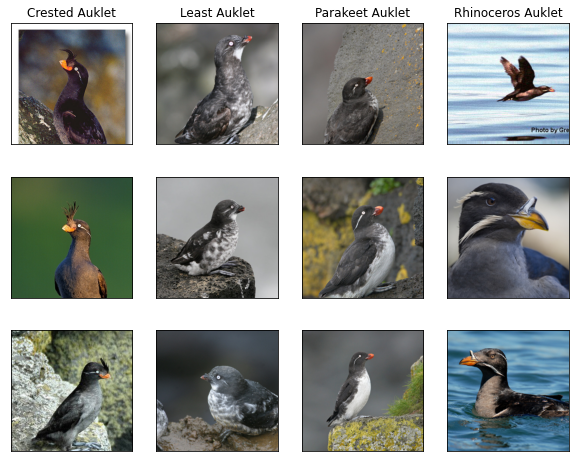

In [ ]:
fig = plt.figure(figsize=(10, 8))
columns = 4
rows = 3
for i in range(columns*rows):
    plt_obj = fig.add_subplot(rows, columns, i+1)
    if i < columns:
        plt_obj.set_title(bird_types[i].split('.')[-1].replace('_', ' '))
    img = Image.open(img_pths[i%columns][i//columns])
    img_min_dim = min(np.array(img).shape[:2])
    img = img.crop((0,0,img_min_dim, img_min_dim))
    img = img.resize((224,224))
    plt.xticks([])
    plt.yticks([])
    plt.imshow(img)
plt.savefig('auklet_birds.png')
plt.show()